# 04. PyTorch Custom Datasets Video Notebook

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.__version__

'2.6.0+cu126'

## 1 Get data

In [60]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir() :
    print(f"{image_path} directory already exists... skipping download")
else: 
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, suhsi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [61]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [62]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [63]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


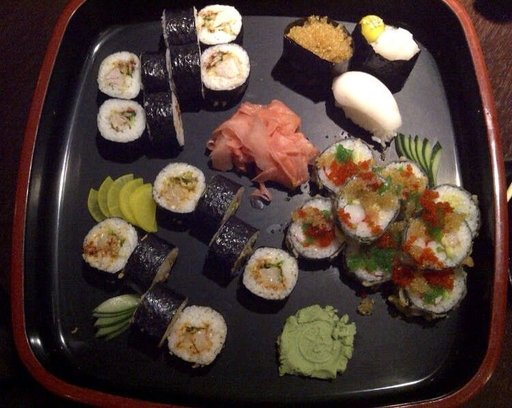

In [64]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

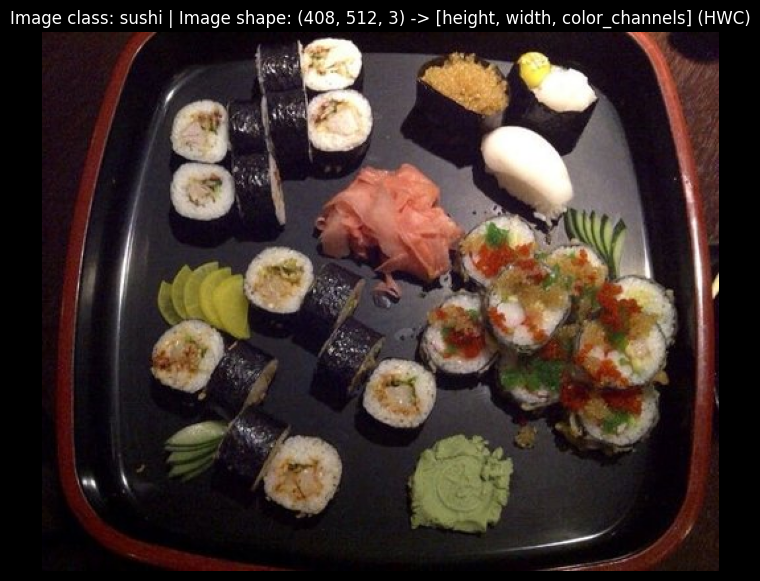

In [65]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [66]:
img_as_array

array([[[33, 13, 15],
        [30, 10, 12],
        [30, 10, 12],
        ...,
        [23, 14, 19],
        [21, 12, 17],
        [20, 11, 16]],

       [[35, 15, 17],
        [32, 12, 14],
        [31, 11, 13],
        ...,
        [21, 12, 17],
        [19, 10, 15],
        [19, 10, 15]],

       [[34, 15, 17],
        [31, 12, 14],
        [30, 11, 13],
        ...,
        [19,  9, 17],
        [18,  8, 16],
        [18,  8, 16]],

       ...,

       [[11,  6, 12],
        [11,  6, 12],
        [11,  6, 12],
        ...,
        [33, 19, 18],
        [33, 19, 19],
        [31, 17, 17]],

       [[ 8,  3,  9],
        [ 9,  4, 10],
        [ 9,  4, 10],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [27, 11, 11]],

       [[ 4,  0,  5],
        [ 5,  0,  6],
        [ 6,  1,  7],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [25,  9,  9]]], dtype=uint8)

## 3. Transforming data

In [67]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [68]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    
    transforms.RandomHorizontalFlip(p=0.5),
    
    transforms.ToTensor()
])

In [69]:
data_transform(img).shape

torch.Size([3, 64, 64])

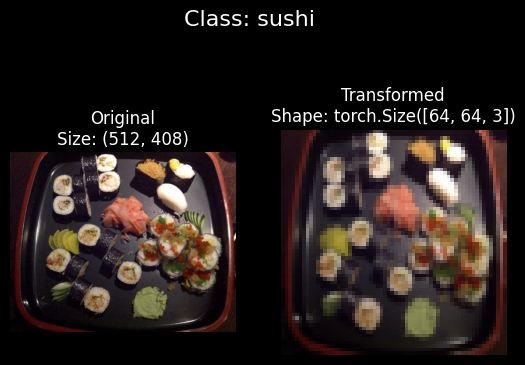

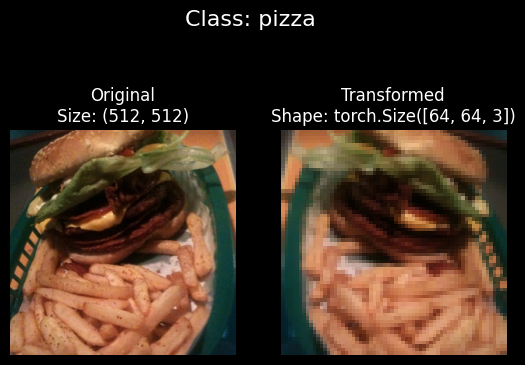

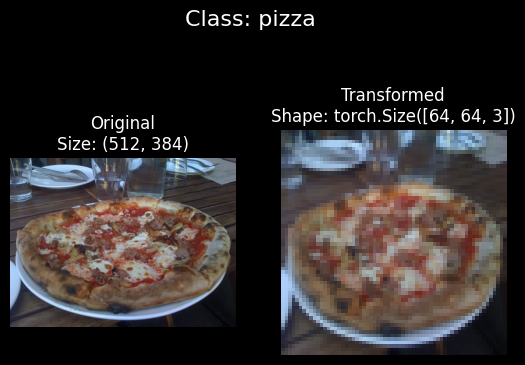

In [70]:
def plot_transformed_images(image_paths, transform, n = 3, seed=42):
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as F:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(F)
            ax[0].set_title(f"Original\nSize: {F.size}")
            ax[0].axis(False)
            
            transformed_image = transform(F).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using 'ImageFolder'

In [71]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [72]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [73]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [74]:
# train_data.targets

In [75]:
# train_data.imgs

In [76]:
len(train_data), len(test_data)

(225, 75)

In [77]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [78]:
img, label = train_data[0]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [79]:
label

0

In [80]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

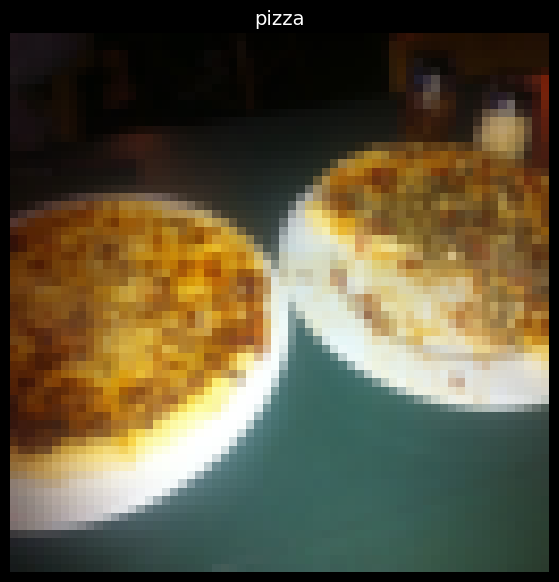

In [81]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

#plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into DataLoader's

In [82]:
!nvidia-smi

Tue Apr  1 10:42:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8             13W /   98W |     191MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [83]:
import os
os.cpu_count()

16

In [84]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                            #   num_workers=os.cpu_count(),
                            num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x242f5a1a3b0>,
 <torch.utils.data.dataloader.DataLoader at 0x242f5a182b0>)

In [85]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [86]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom Dataset

In [87]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [88]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [89]:
# Setup path for target directory

target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [90]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [91]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
    
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
  # 2. Raise an error if class names could not be found
  if not classes:
      raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")


  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_names:i for i, class_names in enumerate(classes)}
    
  return classes, class_to_idx

In [92]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom 'Dataset' to replicate 'ImageFolder'

In [93]:
from torch.utils.data import Dataset 

class ImageFolderCustom(Dataset):
    
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [94]:
from torchvision import transforms

train_tranforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_tranforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [95]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_tranforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_tranforms)

In [96]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x242f59f8730>,
 <__main__.ImageFolderCustom at 0x242f59f94b0>)

In [97]:
len(train_data), len(train_data_custom)

(225, 225)

In [98]:
len(test_data), len(test_data_custom)

(75, 75)

In [99]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [100]:
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


In [101]:
import torchvision
torchvision

<module 'torchvision' from 'c:\\Users\\daksh\\anaconda3\\envs\\pytorch_env\\lib\\site-packages\\torchvision\\__init__.py'>

### 5.3 Create a function to display random images


In [102]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)
    
    random_sample_idx = random.sample(range(len(train_data_custom)), k=n)
    
    plt.figure(figsize=(16,8))
    
    for i, target_sample in enumerate(random_sample_idx):
        target_img, target_label = dataset[target_sample][0], dataset[target_sample][1]
        
        target_img_adjust = target_img.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(target_img_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_img_adjust.shape}"
        plt.title(title)

        

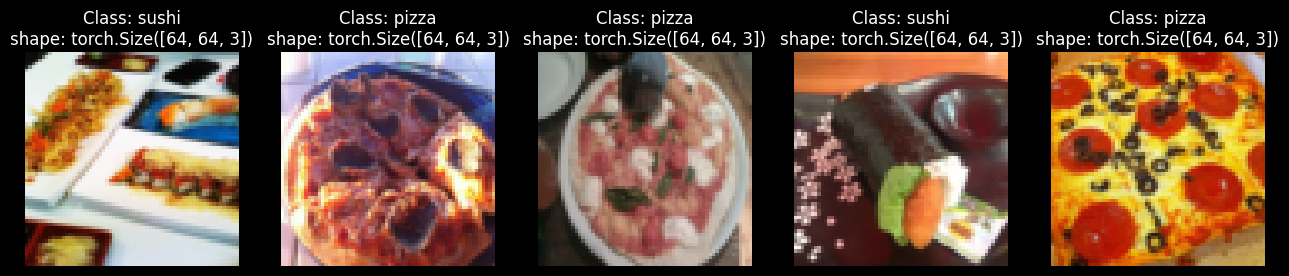

In [103]:
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n=5,
                      seed=42)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


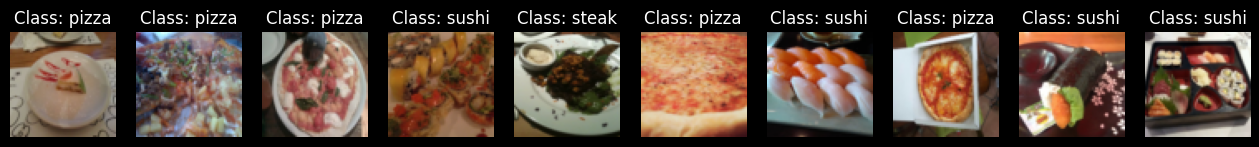

In [104]:
display_random_images(dataset=train_data_custom,
                      classes=class_names,
                      n=20,
                      seed=22)

### 5.4 Turn custom loaded images into `DataLoader's`

In [105]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x242e3f635b0>,
 <torch.utils.data.dataloader.DataLoader at 0x242f5df7940>)

In [106]:
print(iter(train_dataloader_custom))

In [107]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

In [108]:
from torchvision import transforms

train_tranforms = transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_tranforms = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

In [109]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [110]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

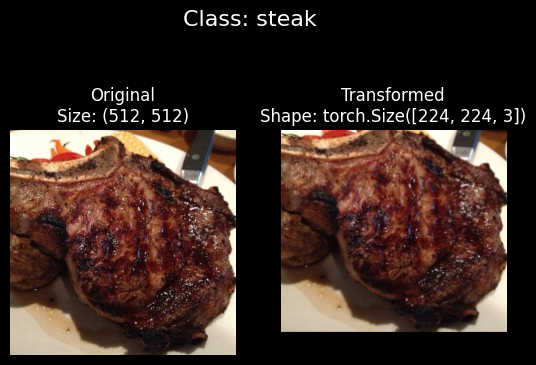

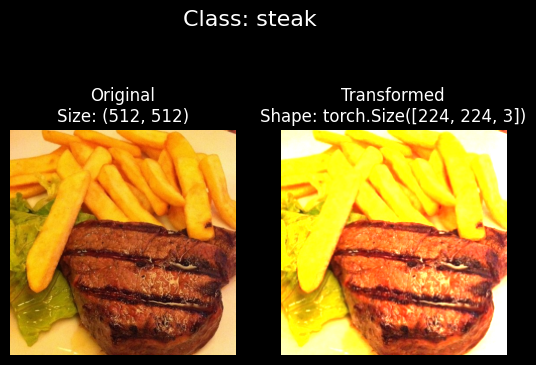

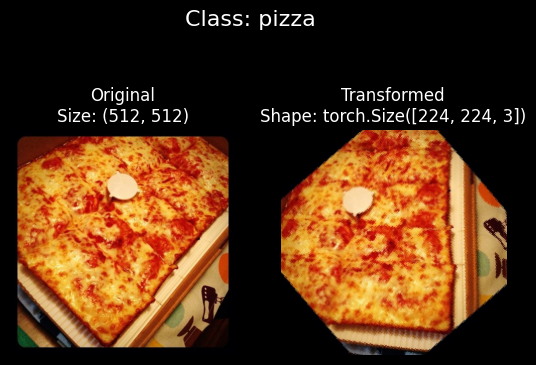

In [111]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_tranforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [112]:
simple_transform = transforms.Compose([
    transforms.Resize(size=[64, 64]),
    transforms.ToTensor()
])

In [113]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform,
                                  target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [114]:
os.cpu_count()

16

In [115]:
import os 
from torch.utils.data import DataLoader

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x242e529f3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x242e3f63670>)

### 7.2 Create TinyVGG model class

In [116]:
class TinyVGG(nn.Module):
    
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x

        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [117]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Training on device:", device)

Training on device: cuda:0


In [118]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version used by PyTorch:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("GPU Details:", torch.cuda.get_device_properties(0))

PyTorch version: 2.6.0+cu126
CUDA version used by PyTorch: 12.6
cuDNN version: 90501
GPU Details: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Laptop GPU', major=8, minor=6, total_memory=16383MB, multi_processor_count=48, uuid=9a1c8097-8bec-df4f-bd52-11ae160f9fb3, L2_cache_size=4MB)


In [119]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [120]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [121]:
model_0(image_batch.to(device))

tensor([[ 0.0208, -0.0020,  0.0095],
        [ 0.0184,  0.0025,  0.0067],
        [ 0.0177,  0.0010,  0.0095],
        [ 0.0244, -0.0033,  0.0096],
        [ 0.0199,  0.0007,  0.0108],
        [ 0.0213,  0.0020,  0.0050],
        [ 0.0210,  0.0002,  0.0125],
        [ 0.0216, -0.0020,  0.0097],
        [ 0.0245, -0.0048,  0.0085],
        [ 0.0202, -0.0005,  0.0109],
        [ 0.0222, -0.0004,  0.0098],
        [ 0.0223, -0.0022,  0.0094],
        [ 0.0219, -0.0037,  0.0084],
        [ 0.0229, -0.0018,  0.0103],
        [ 0.0216, -0.0044,  0.0095],
        [ 0.0221, -0.0041,  0.0094]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

###  Use torchinfo to get an idea of the shapes going through our model

In [122]:
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [123]:
import torch
from torch import nn

device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device1

device(type='cuda', index=0)

### 7.5 Create train and test loops functions

In [136]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device=device1
):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    # for X, y in enumerate(dataloader):
    for X, y in dataloader:
        
        X, y = X.to(device), y.to(device)
        # print(X.device, y.device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss = train_loss + loss
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=-1), dim=-1)
        train_acc = train_acc + ((y_pred_class == y).sum().item()/len(y_pred))
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc


In [125]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device=device1
):
    
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        
        # for X, y in enumerate(dataloader):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            print(X.device, y.device)
            
            test_pred_logits = model(X)
            
            loss = loss_fn(test_pred_logits, y)
            test_loss = test_loss + loss
            
            test_pred_labels = torch.argmax(test_pred_logits, dim=-1)
            test_acc = test_acc + ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc
    

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [137]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device1):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        
    return results

### 7.7 Train and evaluate model 0

In [177]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

device1 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device1)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device1)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:23<01:33, 23.49s/it]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 0 | Train loss: 1.1070 | Train acc: 0.3042 | Test loss: 1.0917 | Test acc: 0.5938
cuda:0 cuda:0
cuda:0 cuda:0


 40%|████      | 2/5 [00:59<01:32, 30.99s/it]

cuda:0 cuda:0
Epoch: 1 | Train loss: 1.0901 | Train acc: 0.3375 | Test loss: 1.0681 | Test acc: 0.6042
cuda:0 cuda:0
cuda:0 cuda:0


 60%|██████    | 3/5 [01:43<01:13, 36.94s/it]

cuda:0 cuda:0
Epoch: 2 | Train loss: 1.0561 | Train acc: 0.5125 | Test loss: 1.0616 | Test acc: 0.3314
cuda:0 cuda:0
cuda:0 cuda:0


 80%|████████  | 4/5 [02:14<00:34, 34.61s/it]

cuda:0 cuda:0
Epoch: 3 | Train loss: 0.9656 | Train acc: 0.5833 | Test loss: 1.0502 | Test acc: 0.4451
cuda:0 cuda:0
cuda:0 cuda:0


100%|██████████| 5/5 [02:51<00:00, 34.31s/it]

cuda:0 cuda:0
Epoch: 4 | Train loss: 0.9146 | Train acc: 0.5458 | Test loss: 0.9807 | Test acc: 0.4631
Total training time: 171.554 seconds


In [183]:
device = next(model_0.parameters()).device
print("Model is on device:", device)

Model is on device: cuda:0


In [184]:
torch.cuda.device_count()

1

In [185]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3080 Laptop GPU'

In [186]:
model_0_results

{'train_loss': [tensor(1.1070, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0901, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0561, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9656, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9146, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.30416666666666664,
  0.3375,
  0.5125,
  0.5833333333333334,
  0.5458333333333333],
 'test_loss': [tensor(1.0917, device='cuda:0'),
  tensor(1.0681, device='cuda:0'),
  tensor(1.0616, device='cuda:0'),
  tensor(1.0502, device='cuda:0'),
  tensor(0.9807, device='cuda:0')],
 'test_acc': [0.59375,
  0.6041666666666666,
  0.331439393939394,
  0.44507575757575757,
  0.4630681818181818]}

### 7.8 Plot the loss curves of Model 0

In [187]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [188]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    loss = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in results["train_loss"]]
    test_loss = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in results["test_loss"]]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how mnay epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend() 

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

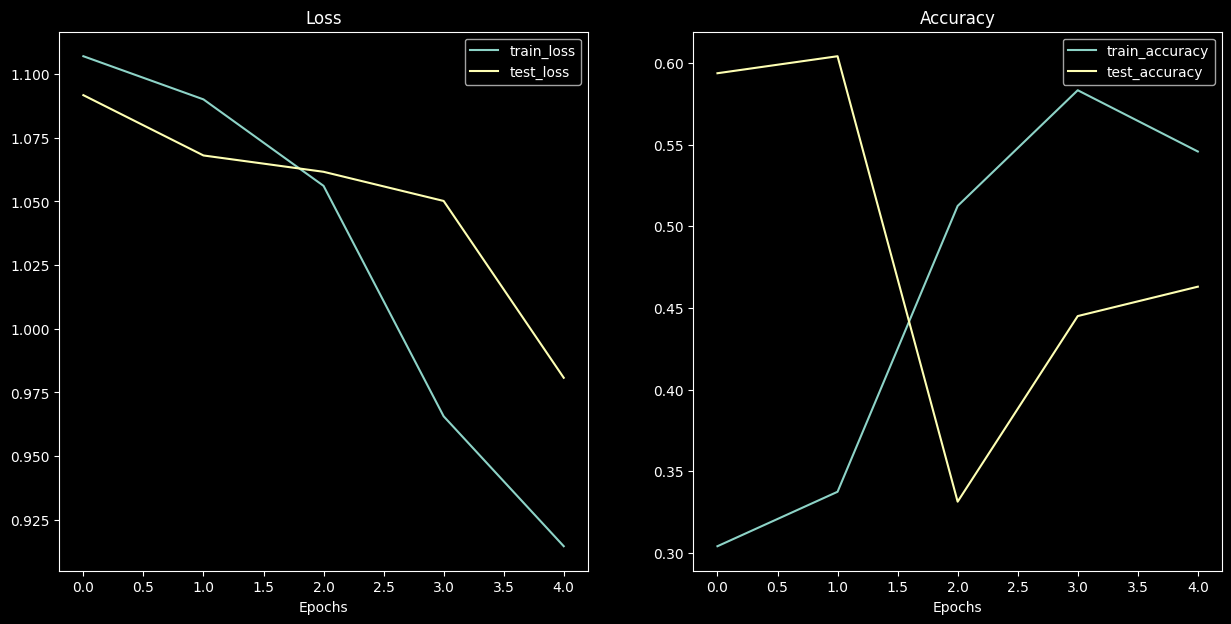

In [189]:
plot_loss_curves(model_0_results) 

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [190]:
from torchvision import transforms

train_tranform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_tranform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

9.2 Create train and test `Dataset's` and `DataLoader's` with data augmentation

In [191]:
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_tranform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_tranform_simple)

In [192]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

### 9.3 Construct and train model 1

In [193]:
import torch

device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Training on device:", device0)

Training on device: cuda:0


In [194]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device0)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [203]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device0)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:01<00:04,  1.08s/it]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 0 | Train loss: 0.9366 | Train acc: 0.4609 | Test loss: 0.9869 | Test acc: 0.3930


 40%|████      | 2/5 [00:02<00:03,  1.02s/it]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 1 | Train loss: 0.8627 | Train acc: 0.5938 | Test loss: 1.0913 | Test acc: 0.3125


 60%|██████    | 3/5 [00:02<00:01,  1.04it/s]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 2 | Train loss: 0.9687 | Train acc: 0.4727 | Test loss: 1.0834 | Test acc: 0.3930


 80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 3 | Train loss: 0.9644 | Train acc: 0.4961 | Test loss: 1.0235 | Test acc: 0.4337


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
Epoch: 4 | Train loss: 0.8777 | Train acc: 0.5977 | Test loss: 1.0409 | Test acc: 0.4242
Total training time for model_1: 4.704 seconds


In [204]:
model_1_results

{'train_loss': [tensor(0.9366, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8627, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9687, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9644, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8777, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.4609375, 0.59375, 0.47265625, 0.49609375, 0.59765625],
 'test_loss': [tensor(0.9869, device='cuda:0'),
  tensor(1.0913, device='cuda:0'),
  tensor(1.0834, device='cuda:0'),
  tensor(1.0235, device='cuda:0'),
  tensor(1.0409, device='cuda:0')],
 'test_acc': [0.39299242424242425,
  0.3125,
  0.39299242424242425,
  0.43371212121212127,
  0.42424242424242425]}

### 9.4 Plot the loss curves of model 1

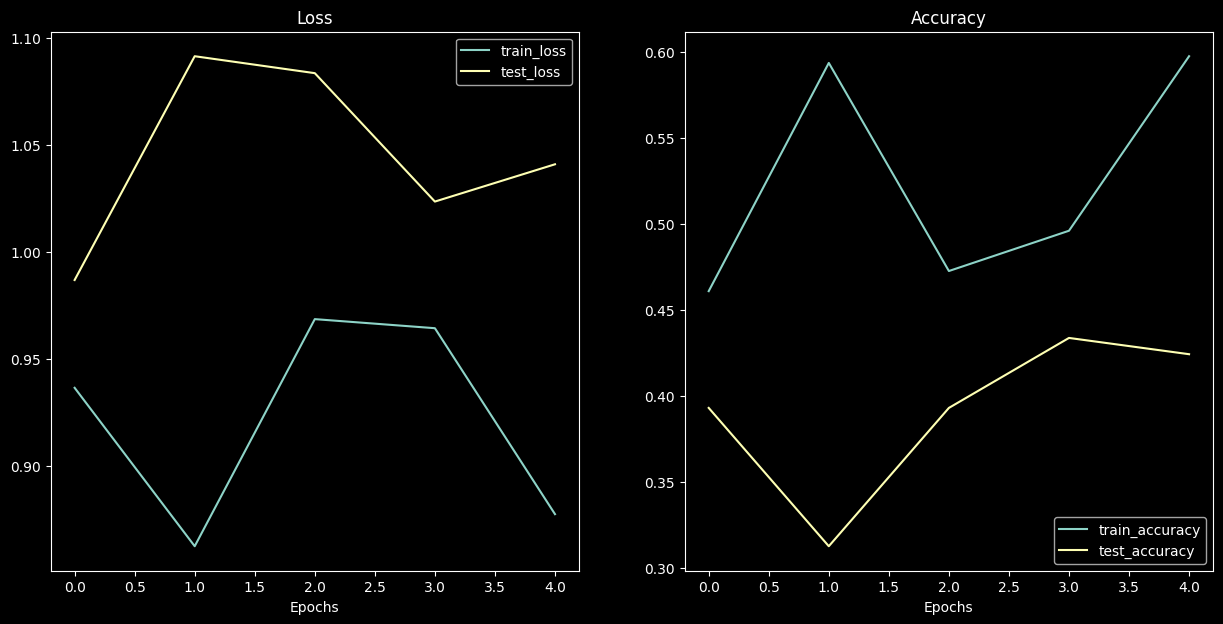

In [205]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [206]:
import pandas as pd

model_0_results["train_loss"] = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in model_0_results["train_loss"]]
model_0_results["test_loss"] = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in model_0_results["test_loss"]]

model_1_results["train_loss"] = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in model_1_results["train_loss"]]
model_1_results["test_loss"] = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in model_1_results["test_loss"]]

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0   1.1070343   0.304167  1.0917401  0.593750
1   1.0900791   0.337500  1.0680547  0.604167
2   1.0561178   0.512500  1.0616422  0.331439
3  0.96560794   0.583333  1.0501869  0.445076
4     0.91458   0.545833  0.9807393  0.463068

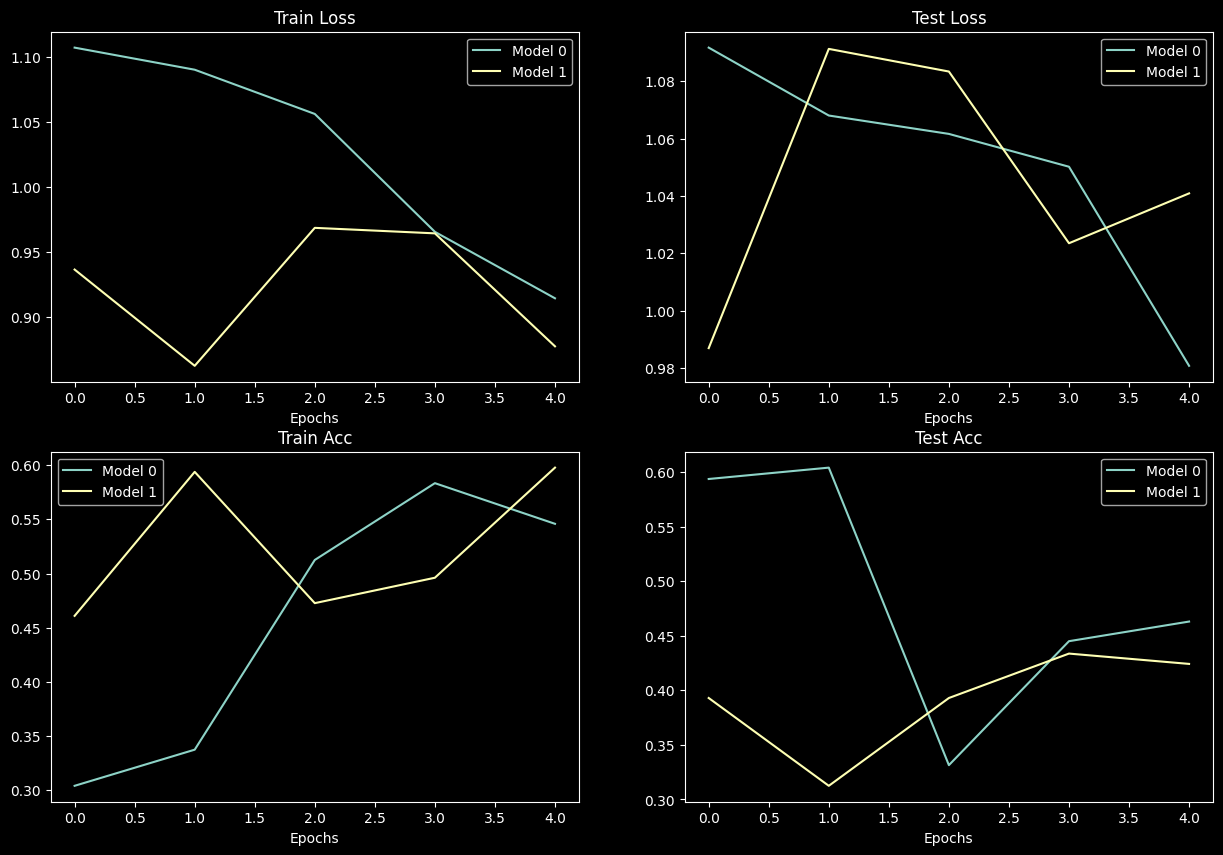

In [207]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

In [208]:
import requests

import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

data\04-pizza-dad.jpeg already exists, skipping download...


### 11.1 Loading in a custom image with PyTorch

In [209]:
custom_image_path

WindowsPath('data/04-pizza-dad.jpeg')

In [212]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

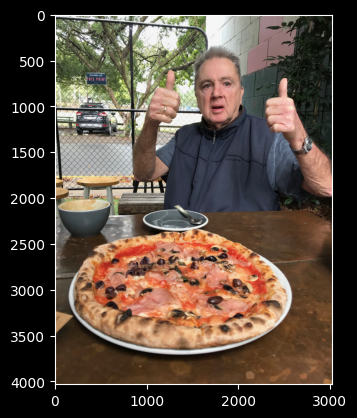

In [213]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [214]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [221]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.

custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

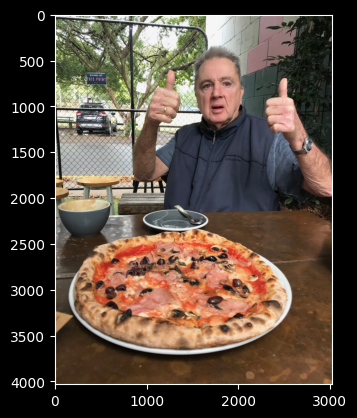

In [223]:
plt.imshow(custom_image.permute(1, 2, 0))

In [222]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [224]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


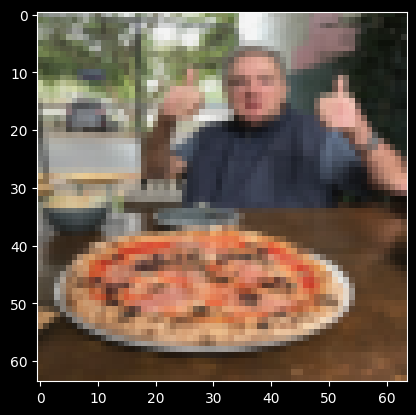

In [225]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [226]:
# This will error: image not on right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [227]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [228]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [229]:
# This should this work? (added a batch size...)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.6396, -0.9452, -0.5723]], device='cuda:0')

In [230]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.6655, 0.1364, 0.1981]], device='cuda:0')

In [231]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label
     

tensor([0])

In [232]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [235]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

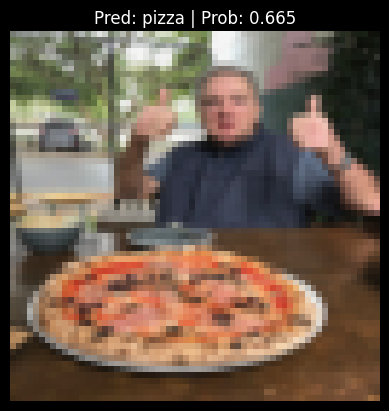

In [238]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)